### EDS 296: Assignment 2 - Geospatial Analysis

#### Author: Liz Peterson
#### Date: 5-12-2025

### Accessing CMIP6 data


1. Using the CMIP6 database hosted on Amazon Web Services, choose any two models you like: use both their historical simulations and future projections from one of the four major SSPs (ssp126, ssp245, ssp370, or ssp585). Provide a brief description of the models and scenarios you chose to include.

#### Set up

In [1]:
# Import libraries 
import xarray as xr
import matplotlib.pyplot as plt
import intake
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime

In [2]:
# Open the CMIP6 data catalog & store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

#### Choose two models & one SSP

I chose to use the CanESM5 and MIROC6 models with the SSP 585 emissions scenario. The emissions scenario is mostly a wors-case, high-emissions scenario which would likely lead to more extreme impacts. I am interested in looking at surface air temperature in antarctica as a way to investigate how ice extent might change. These models both do a good job at projecting the warming and sea ice extent, which is why I chose them.

2. Access information from your chosen models and scenario, for any climate variable you like; however, note that three-dimensional data is generally larger and can be slower to load, so I recommend either choosing a two-dimensional data field or reading in only the surface level if you choose 3D information. Some common choices of variables to analyze, and their CMIP names, include:

- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)

In [3]:
# Query catalog for my two models 
activity_ids = ['ScenarioMIP', 'CMIP']

# Select two models 
source_id = ['CanESM5', 'MIROC6']

# Select historical and ssp370 experimental configurations  
experiment_ids = ['historical', 'ssp585']

# Choose ensemble member id (starting condtions, internal variation) 
member_id = 'r1i1p1f1'

# Choose monthly time resolution
table_id = 'Amon'

# Select air temperature (tas) for the environmental varaible
variable_id = 'tas'

In [4]:

# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC6/histori...,NaN,20181212
1,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,ScenarioMIP,MIROC,MIROC6,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/MIROC/MIROC6/...,NaN,20190627


In [5]:
# Read in data and store as xarray object (CanESM5)
hist_canESM = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True}, consolidated=True)
ssp_canESM = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True}, consolidated=True)

# Read in data and store as xarray object (MIROC)
hist_miroc = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True}, consolidated=True)
ssp_miroc = xr.open_zarr(res.df['zstore'][3], storage_options={'anon': True}, consolidated=True)

In [6]:
# Concatenate historical and future projection data
# CanESM5 model 
canESM_tas = xr.concat([hist_canESM, ssp_canESM], dim="time")

# MIROC model
miroc_tas = xr.concat([hist_miroc, ssp_miroc], dim="time")

# Convert time to datetime64 format
canESM_tas['time'] = canESM_tas.time.astype('datetime64[ns]')
miroc_tas['time'] = miroc_tas.time.astype('datetime64[ns]')

# Sort by time for future filtering 
canESM_tas = canESM_tas.sortby('time')
miroc_tas = miroc_tas.sortby('time')

In [7]:
# Confirm data contains time ranges of interest 
print(canESM_tas.time.values[0])
print(canESM_tas.time.values[-1])

print(miroc_tas.time.values[0])
print(miroc_tas.time.values[-1])

1677-09-25T00:25:26.290448384
2262-03-16T12:00:00.000000000
1850-01-16T12:00:00.000000000
2100-12-16T12:00:00.000000000


3. Choose a region that you’re interested in to analyze, anywhere in the world. This should be a region that’s fairly large - think, the size of a large country or a sizable fraction of a continent. As you did for HW1, describe in markdown text some aspects of the climate of your region: what are the interesting features there, and how might you expect that climate change would impact the area?

As mentioned above, I am interested in looking at antarctica. This area has been so important in the popular imagination of climate change, which has made it one that I've been particularly interested in. I am looking at surface air temperature, but surely this can act as a gateway to exploring other climate factors, like sea ice melting. 

In [15]:
antarctica = [50.273438, 19.12441, 59.589844, 28.748397]

4. Choose two separate time periods, each 30-50 years in length, and describe briefly why you chose these periods: then make some maps of the time average of your selected variable.
a. Map the average over each time period separately
b. Map the difference in the averages between the two time periods (note: make sure to label which time period you subtracted from which!) For both your sets of maps, display some relevant political/geographic boundaries overlaid on the region: we saw some examples of how to do this using the Cartopy “feature” toolbox in the mapping tutorials.

In [16]:
# Define time periods (historical and projected)
hist = [1990, 2020]
proj = [2050, 2100]

# Filter data of each model to historical and future time periods 
# CanESM 
canESM_tas_hist = canESM_tas.sel(time=slice(str(hist[0])+"-01-01", str(hist[1])+"-12-31"))
canESM_tas_proj = canESM_tas.sel(time=slice(str(proj[0])+"-01-01", str(proj[1])+"-12-31"))

# MIROC miroc_tas
miroc_tas_hist = miroc_tas.sel(time=slice(str(hist[0])+"-01-01", str(hist[1])+"-12-31"))
miroc_tas_proj = miroc_tas.sel(time=slice(str(proj[0])+"-01-01", str(proj[1])+"-12-31"))


# Calc averages over time periods and convert to celcius 
canESM_tas_histmn = canESM_tas_hist.mean(dim="time") - 273.15
canESM_tas_projmn = canESM_tas_proj.mean(dim="time") - 273.15

miroc_tas_histmn = miroc_tas_hist.mean(dim="time") - 273.15
miroc_tas_projmn = miroc_tas_proj.mean(dim="time") - 273.15

I chose the time periods 1990-2020 to get the most recent historical data I could. I wanted to look into the turn of the next century for my projection, so I decided to use 2050-2100. For an emissions scenario as extreme as the SSP 585, it seemed only appropriate to look ahead quite far.

#### CanESM historical plot

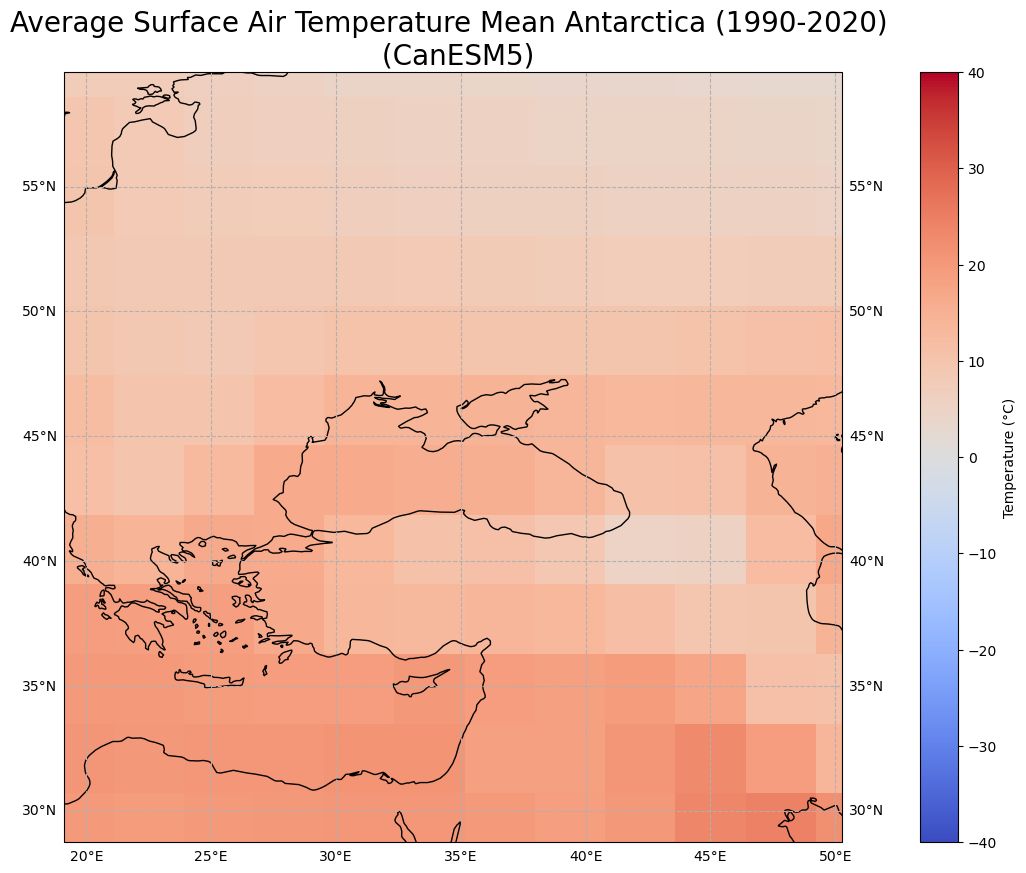

In [32]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Make figure and axes
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot 
plot = ax.pcolormesh(canESM_tas_histmn.lon, canESM_tas_histmn.lat, canESM_tas_histmn["tas"], transform=map, 
                     cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(antarctica, crs=ccrs.PlateCarree())

# Add coastline to define region
ax.add_feature(cfeature.COASTLINE)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title
ax.set_title("Average Surface Air Temperature Mean Antarctica (1990-2020) \n (CanESM5)", fontsize= 20)
plt.show()

#### CanESM projected plot - SSP 585

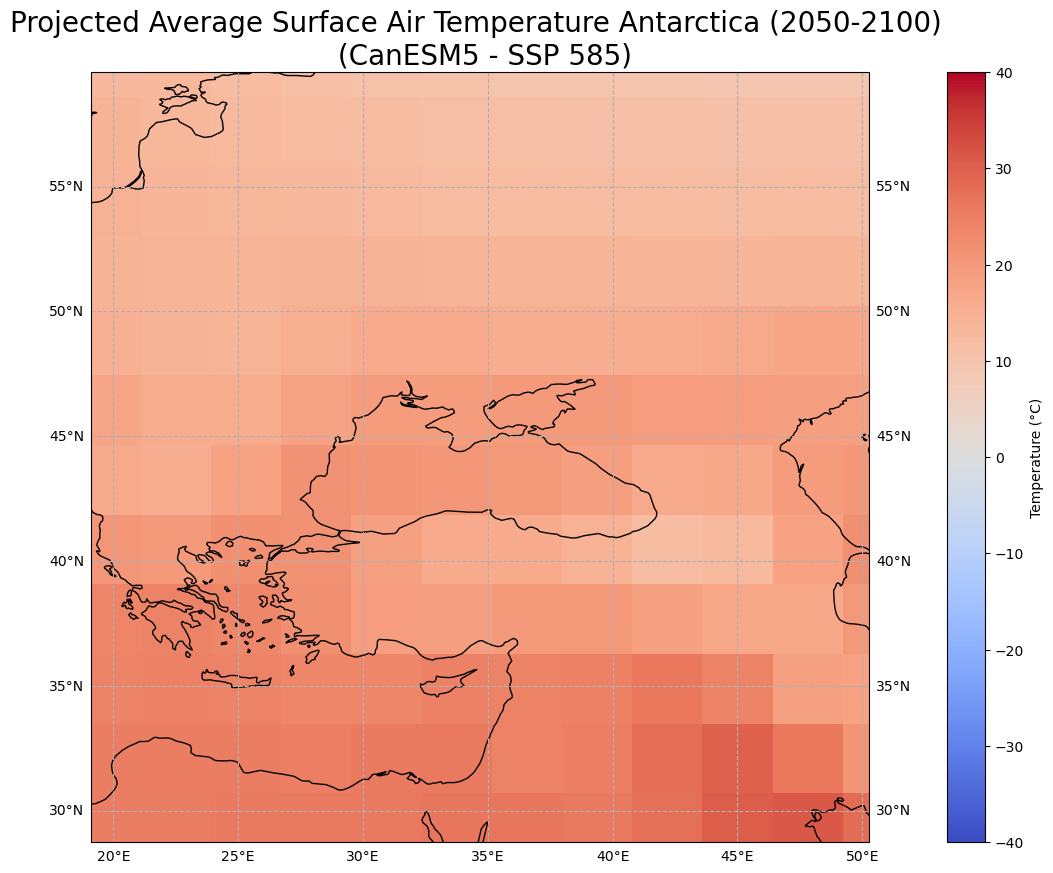

In [31]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Make figure and axes
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot
plot = ax.pcolormesh(canESM_tas_projmn.lon, canESM_tas_projmn.lat, canESM_tas_projmn["tas"], transform=map, 
                     cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(antarctica, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline to define region
ax.add_feature(cfeature.COASTLINE)

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Projected Average Surface Air Temperature Antarctica (2050-2100) \n (CanESM5 - SSP 585)", fontsize= 20)
plt.show()

#### MIROC6 historical plot

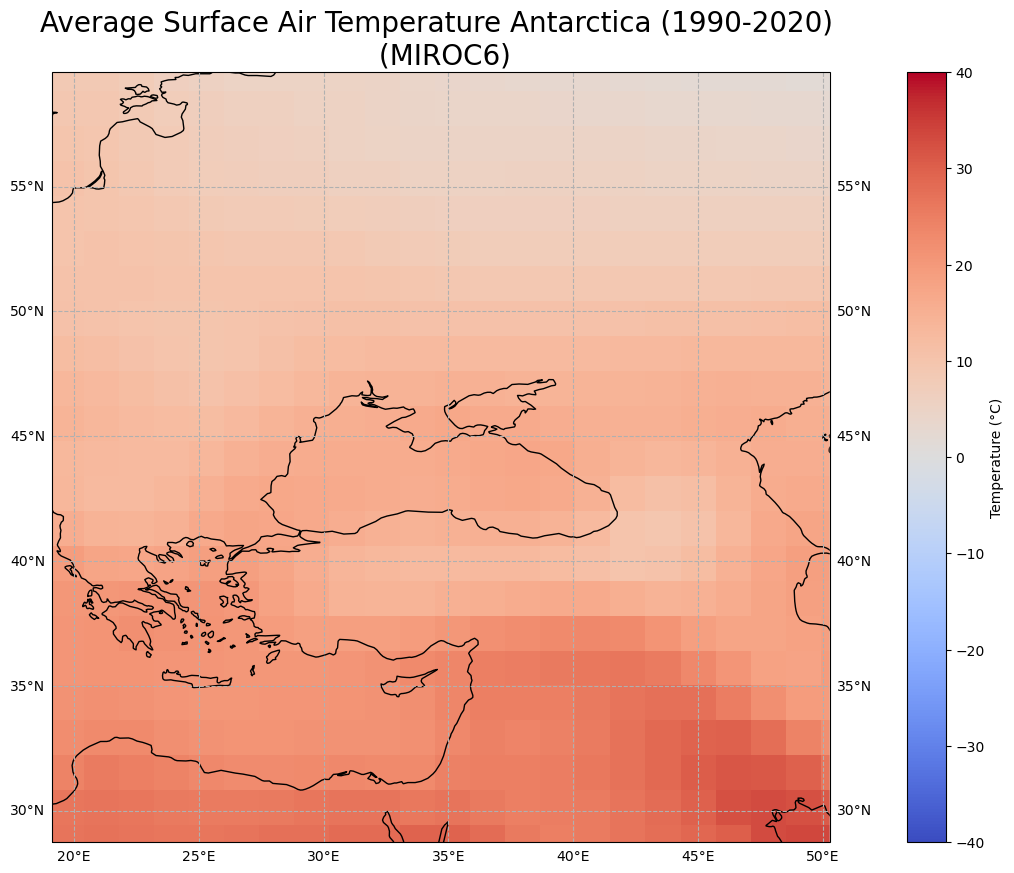

In [33]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot 
plot = ax.pcolormesh(miroc_tas_histmn.lon, miroc_tas_histmn.lat, miroc_tas_histmn["tas"], transform=map, 
                     cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(antarctica, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline to define region
ax.add_feature(cfeature.COASTLINE)

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Average Surface Air Temperature Antarctica (1990-2020) \n (MIROC6)", fontsize= 20)
plt.show()

#### MIROC6 projected plot - SSP 585

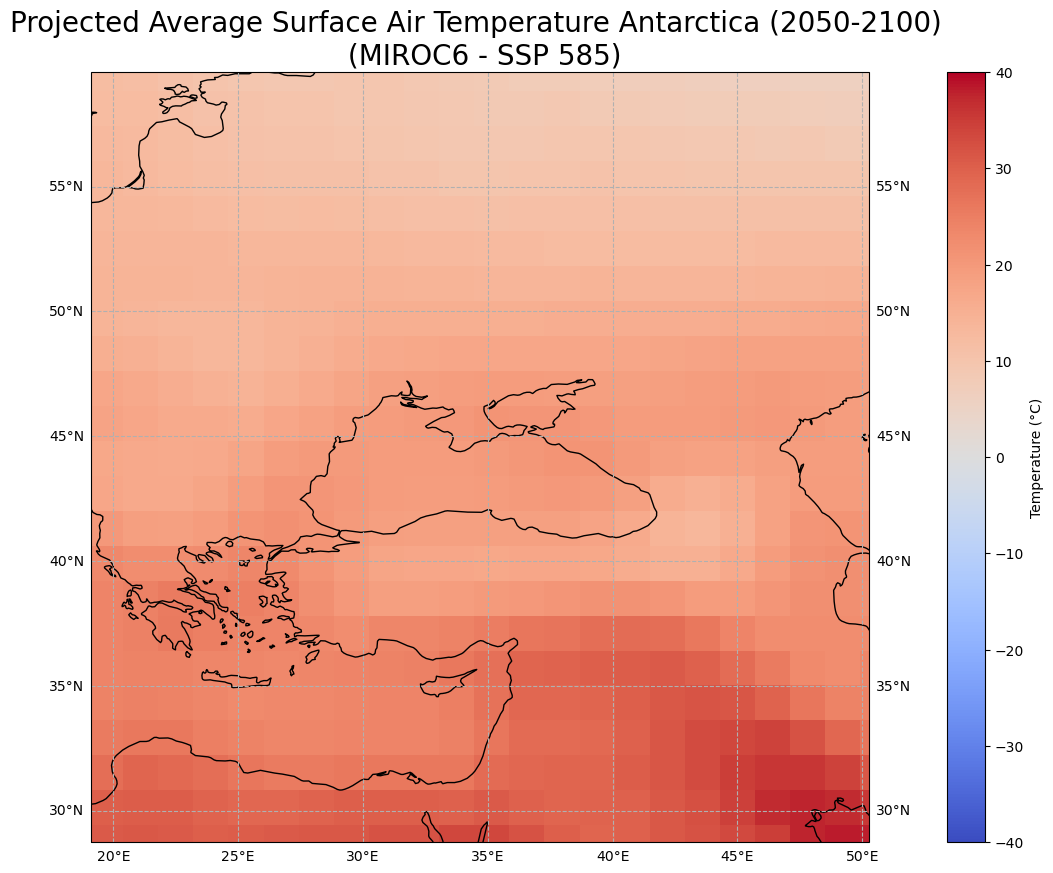

In [34]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot
plot = ax.pcolormesh(miroc_tas_projmn.lon, miroc_tas_projmn.lat, miroc_tas_projmn["tas"], transform=map, 
                     cmap="coolwarm", vmin=-40, vmax=40)

# Set spatial extent of plot
ax.set_extent(antarctica, crs=ccrs.PlateCarree())


# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline to define region
ax.add_feature(cfeature.COASTLINE)

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Projected Average Surface Air Temperature Antarctica (2050-2100) \n (MIROC6 - SSP 585)", fontsize= 20)
plt.show()

5. Write 1-2 paragraphs in markdown text describing the results of your plot, and what you think they might mean for humans or ecosystems located in your study region.

The bottom half of the map is where we are really focused, because that is the area that is covered by ice. We see a clear trend that the surface air temperature is rising from the historical plot to the projections plot. This will inevitably have important implications for the world. Most importantly, because there is so much ice covering antartica, rising surface air temperatures could lead to ice melt. This level of ice melt could mean huge sea level rise throughout the world. While this conversation about sea rise level from ice melt has been in the popular imagination for a while, perhaps seeing these plots and tangible evidence for this rising temperature could be more motivation for change, especially seeing as this is under the highest emission scenario possible. 